In [10]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
transform = transforms.Compose([transforms.ToTensor()])
trainset_tmp = datasets.MNIST('~/', download=True, train=True, transform=transform)
trainloader_tmp = torch.utils.data.DataLoader(trainset_tmp, batch_size=10_000, shuffle=True)
testset = datasets.MNIST('~/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False)

In [11]:
def data_divides__minst():
    Train = []
    for image in trainset_tmp:
        for i in range(10):
            if image[1] ==i:
                Ima = image[0][0].reshape(1,784)
                number = np.array([0 for i in range(10)])
                number[i] = 1
                Train.append([np.array(Ima[0][:]),number[:]])
    return Train
Train = data_divides__minst()

def data_divides__minst_test():
    Test = []
    for image in testset:
        for i in range(10):
            if image[1] ==i:
                Ima = image[0][0].reshape(1,784)
                number = np.array([0 for i in range(10)])
                number[i] = 1
                Test.append([np.array(Ima[0][:]),number[:]])
    return Test
Test = data_divides__minst_test()
#训练集测试集合处理为球面数据
Test_data = []
for image in Test:
    image_pic = image[0]/10
    a = 2/(sum(image_pic*image_pic)+1)
    Ima = np.append(image_pic*a, a-1)
    Test_data.append([Ima[:],image[1]])

In [12]:
def data_divides__minst_test():
    Test = []
    for image in testset:
        for i in range(10):
            if image[1] ==i:
                Ima = image[0][0].reshape(1,784)
                number = np.array([0 for i in range(10)])
                number[i] = 1
                Test.append([np.array(Ima[0][:]),number[:]])
    return Test
Test = data_divides__minst_test()

In [13]:
#训练集测试集合处理为球面数据
Test_data = []
for image in Test:
    image_pic = image[0]/10
    a = 2/(sum(image_pic*image_pic)+1)
    Ima = np.append(image_pic*a, a-1)
    Test_data.append([Ima[:],image[1]])

In [5]:
import numpy as np
import math
import random
import time
class Sphere_SGD():
    def __init__(self, d, gamma_0, theta, t, s,N):
        self.d = d
        self.s = s
        self.gamma_0 = gamma_0
        self.theta = theta
        self.t = t
        self.f_hat = [0]
        self.f_bar = [0]
        self.sgd_f = [0 for k in range(self.d)]
        self.Z_0 = np.array(1)
        self.Z_1 = self.d*np.ones(self.d)
        self.Z_2 = [-(self.d+2)/2,np.zeros(self.d),np.ones((self.d,self.d))*(self.d*(self.d+2))/2]
        self.Znt = [self.Z_0]
        self.ZntX = []
        self.order = 0
        self.dimPiLn = 1
        self.N = N
        self.F_hat =[self.f_hat[:] for i in range(10)]
        self.F_bar =[self.f_hat[:] for i in range(10)]
        
    
    def update_Z_nt(self):
        if self.order == 1:
            coe = 1/(self.d+1)**(2*self.s)
            self.Znt.append(coe*self.Z_1)
        elif self.order == 2:
            coe = 1/(self.d*(self.d+3)/2)**(2*self.s)
            self.Znt.append(np.zeros((self.d,self.d)))
            self.Znt = [a+coe*b for a,b in zip(self.Znt,self.Z_2)]
    
    def compute_Znt(self,z):
        if self.order == 0:
            self.ZntX = [self.Znt[0]]
        elif self.order == 1:
            self.ZntX = [self.Znt[0]]
            self.ZntX.append(z*self.Znt[1])
        elif self.order == 2:
            self.ZntX = [self.Znt[0]]
            self.ZntX.append(z*self.Znt[1])
            ZZ = np.dot(np.expand_dims(z,1),np.expand_dims(z,0))
            self.ZntX.append(ZZ*self.Znt[2])
            
    def comput_F_bar(self,x):
        Y = np.zeros(10)
        for i in range(10):
            if self.order == 0:
                y = self.F_bar[i][0]
            elif self.order == 1:
                y = self.F_bar[i][0] + np.dot(x,self.F_bar[i][1])
            elif self.order == 2:
                y = self.F_bar[i][0] + np.dot(x,self.F_bar[i][1]) + np.dot(x,np.dot(self.F_bar[i][2],x))
            Y[i] = y
        return Y
    
    def comput_F_hat(self,x):
        Y = np.zeros(10)
        for i in range(10):
            if self.order == 0:
                y = self.F_hat[i][0]
            elif self.order == 1:
                y = self.F_hat[i][0] + np.dot(x,self.F_hat[i][1])
            elif self.order == 2:
                y = self.F_hat[i][0] + np.dot(x,self.F_hat[i][1]) + np.dot(x,np.dot(self.F_hat[i][2],x))
            Y[i] = y
        return Y
    
    def comput_f_sgd(self,x):
        y = sum([j*k for j,k in zip(x,self.sgd_f)])
        return y
    
    def add_gaussian_noise_np(self, np_array, mean=0, std=1):
        noise = np.random.normal(mean, std, np_array.shape)
        self.data = (np_array + noise)/10
        
    def train_generate_data(self):
        DATA = random.sample(Train,1)
        self.add_gaussian_noise_np(DATA[0][0], mean = 0, std = 0.0005)
        a = 2/(sum(self.data*self.data)+1)
        Ima = np.append(self.data*a,a-1)
        return [Ima[:],DATA[0][1]]
    
    def adam_update(self, grad, t, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.m = beta1 * self.m + (1 - beta1) * grad
        self.v = beta2 * self.v + (1 - beta2) * (grad ** 2)
        m_corrected = self.m / (1 - beta1 ** t)
        v_corrected = self.v / (1 - beta2 ** t)
        self.new_grad = lr * m_corrected / (np.sqrt(v_corrected) + epsilon)
        return 0

        
    def algorithm(self,X,Y,epoch):
        gamma_n = self.gamma_0*(epoch**(-self.t))
        #下面是导数，对于图像分类要换掉
        #z = -Y*self.comput_f_hat(X)
        #coe = gamma_n*np.exp(z)*(Y)/(1+np.exp(z))
        F = self.comput_F_hat(X)
        COE = gamma_n*(Y-F)
        if epoch**self.theta >= self.dimPiLn:
            self.order = self.order + 1
            self.update_Z_nt()
            if self.order == 1:
                self.dimPiLn = self.d + 1
                for i in range(10):
                    self.F_hat[i].append(np.zeros(self.d))
                    self.F_bar[i].append(np.zeros(self.d))
            elif self.order == 2:
                self.dimPiLn = (d+3)*d/2
                for i in range(10):
                    self.F_hat[i].append(np.zeros((self.d,self.d)))
                    self.F_bar[i].append(np.zeros((self.d,self.d)))
        self.compute_Znt(X)
        Epoch = epoch+1
        for i in range(10):
            coe = COE[i]
            self.F_hat[i] = [ a + coe*b for a,b in zip(self.F_hat[i],self.ZntX) ][:]
            self.F_bar[i] = [ (a + epoch*b)/Epoch for a,b in zip(self.F_hat[i],self.F_bar[i])][:]
        #error = np.log(1+np.exp(z))
        return 0#error 
    
    def algorithm_sgd(self,X,Y,epoch):
        gamma_n = self.gamma_0*(epoch**(-self.t))
        coe = gamma_n*(Y-self.comput_f_sgd(X))
        self.sgd_f = [j + coe*k for j,k in zip(self.sgd_f,X)]

    def test(self,T,epoch):
        Error_last = 0
        Error_ave = 0
        Accac_last = 0
        Accac_ave = 0
        
        for k in range(T):
            Z = Test_data[k]
            #这里误差衡量也要改
            f_hat =self.comput_F_hat(Z[0])
            t_last = np.where(Z[1] == max(Z[1]))==np.where(f_hat==max(f_hat))
            f_ave = self.comput_F_bar(Z[0])
            t_ave =  np.where(Z[1] == max(Z[1]))==np.where(f_ave==max(f_ave))
            #e_ave = np.log(1+np.exp(-t_ave))
            #e_last = np.log(1+np.exp(-t_last))
            e_ave = sum(np.square(f_ave-Z[1]))
            e_last = sum(np.square(f_hat-Z[1]))
            Error_ave += e_ave
            Error_last += e_last
            if t_ave > 0:
                Accac_ave += 1
            if t_last > 0:
                Accac_last += 1
        self.ERROR_last.append(Error_last/T)
        self.ERROR_ave.append(Error_ave/T)
        self.Accuracy_ave.append(Accac_ave/T)
        self.Accuracy_last.append(Accac_last/T)
        print(epoch,self.ERROR_last[-1], self.ERROR_ave[-1],self.Accuracy_last[-1],self.Accuracy_ave[-1])
        
    def update(self,n,operation):
        self.Accuracy_last = []
        self.Accuracy_ave = []
        self.ERROR_last = []
        self.ERROR_ave = []
        self.Time = []
        start = time.perf_counter()
        T = len(Test_data) #测试数据的多少
        for i in range(1,n+1):
            epoch = i
            DATA = self.train_generate_data()
            error = self.algorithm(DATA[0],DATA[1],epoch)
            '''if error < np.log(2):
                Acc += 1
            Error += error'''
            if epoch in self.N:
                if operation == 'time':
                    end = time.perf_counter()
                    runTime = end - start
                    self.Time.append(runTime)
                    print(epoch, runTime)
                elif operation == 'test':    
                    print(epoch)
                    self.test(T,epoch)
        return [self.ERROR_last,self.ERROR_ave,self.Accuracy_last,self.Accuracy_ave]

In [8]:
d = 785
gamma_0 = 0.5
theta = 0.68
t = 0.
s = 0.505
N = [int(10**(i/5))for i in range(1,36)]
A = [[0 for  i in N] for j in range(6)]
for i in range(1):
    sgd = Sphere_SGD(d, gamma_0+i*10**(-8), theta, t, s,N)
    B = sgd.update(1600004,'test')


1
1 1.3165659704923518 1.0398798361940085 0.1032 0.1032
2
2 1.3183282405558134 1.0279933036582967 0.098 0.1193
3
3 1.2605714459601414 1.000628776753022 0.1028 0.1724
6
6 1.141095053829116 0.9368848099971797 0.1066 0.2234
10
10 1.2275388294070004 0.9269160058794363 0.0975 0.253
15
15 0.9927389853320787 0.8518934168687048 0.1492 0.3283
25
25 1.0035772853205427 0.8329886612702174 0.1848 0.3067
39
39 0.9015244766157572 0.7715326558535798 0.296 0.4252
63
63 0.8899529599672931 0.7275941157140109 0.4275 0.441
100
100 1.1465195103263361 0.6686521011422702 0.2218 0.5243
158
158 0.8802067718532586 0.6137865554474276 0.4117 0.615
251
251 0.5826328340964902 0.5557791311426937 0.7065 0.7066
398
398 0.5634773701712442 0.5117632774734959 0.7397 0.7521
630
630 0.7004437100217304 0.4770214677183846 0.6832 0.7945
1000
1000 0.9368055977759623 0.455043296213119 0.543 0.8166
1584
1584 0.86666494553785 0.4329785376898675 0.5637 0.8384
2511
2511 0.8918309301559312 0.41478486863568287 0.5684 0.8481
3981
3981 

IndexError: list index out of range

In [14]:
d = 785
gamma_0 = 0.5
theta = 0.68
t = 0.
s = 0.505
N = [int(10**(i/5))for i in range(1,36)]
A = [[0 for  i in N] for j in range(6)]
for i in range(1):
    sgd = Sphere_SGD(d, gamma_0+i*10**(-8), theta, t, s,N)
    B = sgd.update(1600004,'time')


1 0.0009230999276041985
2 0.0028240999672561884
3 0.003435899969190359
6 0.005915699992328882
10 0.008300099987536669
15 0.012902699876576662
25 0.022022099932655692
39 0.03305880003608763
63 0.051478799898177385
100 0.07450659992173314
158 0.12276849988847971
251 0.17826179997064173
398 0.26455139997415245
630 0.38626079983077943
1000 0.5988751000259072
1584 0.9474305999465287
2511 1.621741099981591
3981 2.5857241998892277
6309 3.8924014000222087
10000 6.273428800050169
15848 9.942172899842262
25118 973.0885636999737
39810 3092.8485962999985
63095 6455.874876799993
100000 11688.365442099981
158489 19828.598949000007
251188 32618.770144299837


KeyboardInterrupt: 

In [10]:
0

0

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
Acc_t_kernel_sgd_f = np.load("T_kernel_SGD_fashion_mnist.npy")
T_t_kernel_sgd_f = np.array([0.0005009799999982079,
 0.0009745699999967883,
 0.001368659999997135,
 0.002573839999988081,
 0.004177569999995967,
 0.006118459999990477,
 0.010220549999999662,
 0.01581923999999617,
 0.02636652999999285,
 0.04222133999999471,
 0.0682942100000048,
 0.11439372999999478,
 0.1786500899999936,
 0.275865929999992,
 0.4292414699999938,
 0.6756694600000003,
 1.0883373399999954,
 1.7314174000000009,
 2.7480149600000034,
 4.368676339999993,
 6.952403659999999,
 680.6929779,
 1990.1459161,
 4099.198861,
 7370.9535457,
 12490.1947816,
 20506.7754674,
 33138.2233327,
 53986.559556,
 88093.10740040001])
T_t_kernel_sgd_f = np.array([ np.log10(i) for i in T_t_kernel_sgd_f])
print(Acc_t_kernel_sgd_f)

[0.1    0.132  0.1104 0.1977 0.173  0.245  0.2479 0.3091 0.3695 0.5733
 0.6385 0.6814 0.6953 0.7289 0.7459 0.77   0.7818 0.7954 0.8013 0.8061
 0.8073 0.8169 0.837  0.8484 0.8585 0.8671 0.8706 0.8746 0.8789 0.8823]


In [11]:
T_eigen_f = np.load('Time_eigen_fashion_mnist.npy')
Acc_eigen_f = np.load("Accuracy_eigen_pro_fashion_mnist.npy")
T_eigen_f = np.array([ np.log10(i) for i in T_eigen_f])

In [12]:
Acc_kernel_sgd_f = np.array([0.1299,
 0.151,
 0.15109999999999998,
 0.14940000000000003,
 0.194,
 0.21610000000000001,
 0.24969999999999998,
 0.3108000000000001,
 0.39979999999999993,
 0.5092,
 0.5867,
 0.6474,
 0.6904,
 0.7029,
 0.7312000000000001,
 0.754,
 0.7663,
 0.7834,
 0.7941,
 0.8039999999999999,
  0.813,
  0.822,
  0.824,
  0.833,
  0.839])
T_kernel_sgd_f = np.array([0.0002528499811887741,
 0.0003834400326013565,
 0.0004993299953639507,
 0.0008789399871602654,
 0.001523629971779883,
 0.00277239999268204,
 0.006528320000506937,
 0.012937940005213023,
 0.02812640001066029,
 0.06619337995070965,
 0.157205449976027,
 0.4319379299879074,
 1.0840112400008366,
 2.8006134399678557,
 6.9345863200025635,
 16.78869931995869,
 41.566738229966724,
 103.53844304999802,
 260.1907974800095,
 649.8792326700175,
 1699.6164088000078,
 4333.764098099899,
 11353.882223400054,
 29814.589486500015,
 75195.5957392999])
T_kernel_sgd_f= np.array([ np.log10(i) for i in T_kernel_sgd_f])

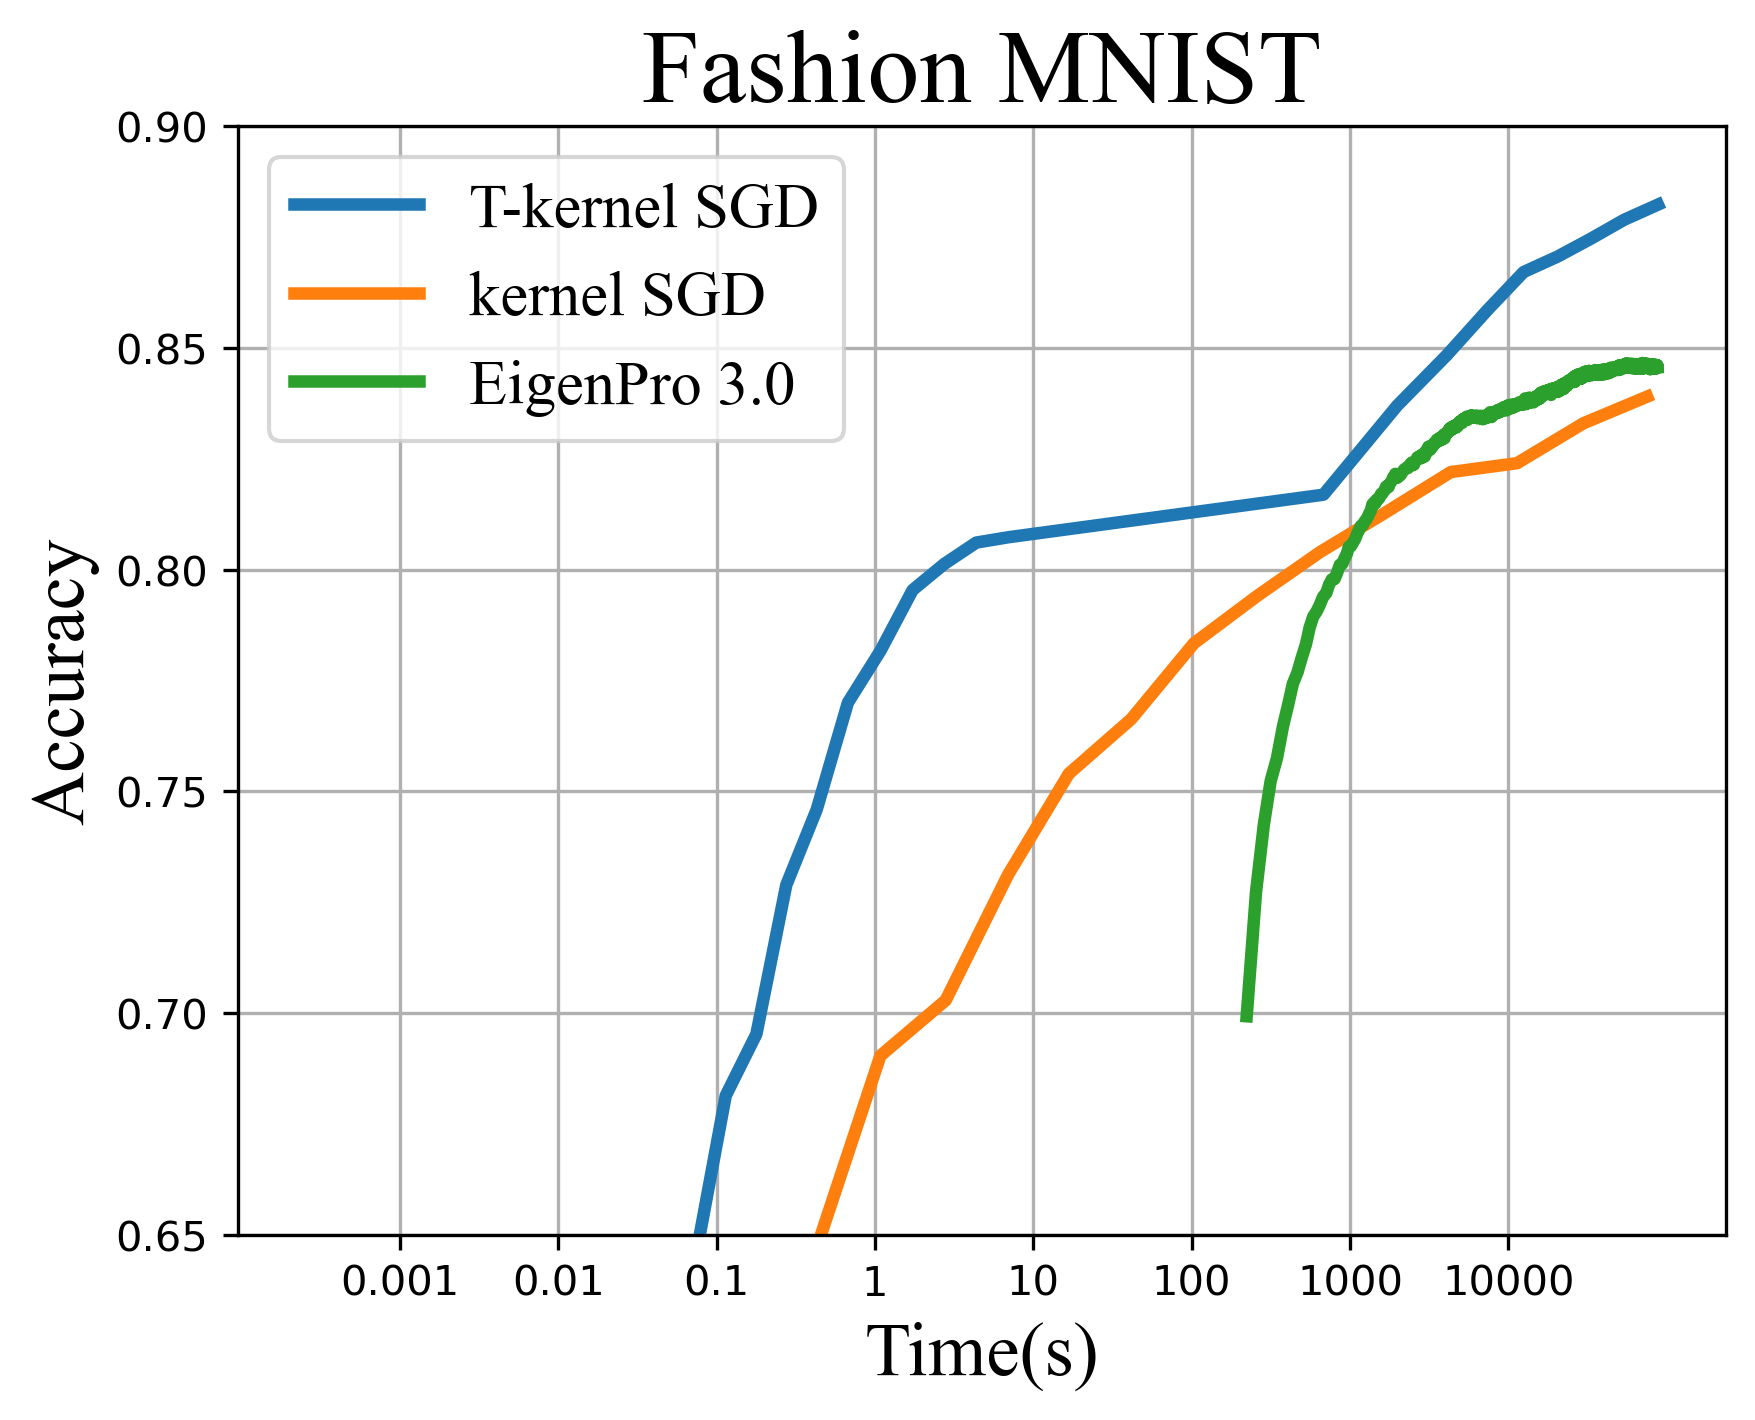

In [13]:

plt.figure(dpi=300)
plt.plot(T_t_kernel_sgd_f, Acc_t_kernel_sgd_f, label='T-kernel SGD',linewidth =3.0,color='#1f77b4')
plt.plot(T_kernel_sgd_f, Acc_kernel_sgd_f, label='kernel SGD',linewidth =3.0,color = '#ff7f0e')
plt.plot(T_eigen_f, Acc_eigen_f, label='EigenPro 3.0',linewidth =3.0,color='#2ca02c')
plt.ylim(0.65,0.9)
plt.xticks(np.array([-3,-2,-1,0,1,2,3,4]),[0.001,0.01,0.1,1,10,100,1000,10000])
plt.xlabel('Time(s)',font={'family':'Times New Roman', 'size':18})
plt.ylabel('Accuracy',font={'family':'Times New Roman', 'size':18})
plt.title('Fashion MNIST', font={'family':'Times New Roman', 'size':25})
font1 = {'family' : 'Times New Roman',
'weight': 'normal',
'size' : 15,
}
plt.grid()
plt.legend(prop=font1)
fig = plt.gcf()
fig.savefig('Fashion MNIST.png')
plt.show()

In [28]:
Acc_t_kernel_sgd=np.array([
    0.1032, 0.1193, 0.1724, 0.2234, 0.253, 0.3283, 0.3067, 0.4252, 0.441,
    0.5243, 0.615, 0.7066, 0.7521, 0.7945, 0.8166, 0.8384, 0.8481, 0.8545,
    0.862, 0.8657, 0.8689, 0.9052, 0.9426, 0.9569, 0.9658, 0.97, 0.9719,
    0.974, 0.9744, 0.9752
])
T_time_kernel_sgd = np.array([0.0008300000336021185, 0.002150799846276641, 0.002672199858352542, 0.0044015999883413315, 0.007089699851348996, 0.009897700045257807, 0.014750799862667918, 0.02263320004567504, 0.03735079988837242, 0.062490700045600533, 0.09747809986583889, 0.1528427000157535, 0.2372971000149846, 0.3810612999368459, 0.6079483998473734, 0.9457649998366833, 1.4456972999032587, 2.200735199963674, 3.429362199967727, 5.453741200035438, 8.538867099909112, 736.8589339999016, 2223.6699230000377, 4588.177053299965, 8341.65114480001, 14473.197116900003, 23924.14041969995, 38864.242818800034, 61929.64553169999, 96773.05006509996])
T_time_kernel_sgd = np.array([ np.log10(i) for i in T_time_kernel_sgd])

In [29]:
Acc_kernel_sgd = np.array([0.1206,
 0.1389,
 0.1453,
 0.1433,
 0.1858,
 0.1932,
 0.2611,
 0.3287999999999999,
 0.44430000000000003,
 0.5549,
 0.6507000000000002,
 0.6976000000000001,
 0.7417999999999999,
 0.7948000000000001,
 0.8207000000000001,
 0.8436,
 0.8536999999999999,
 0.8686,
 0.8722,
 0.8815,
 0.895,
 0.908,
 0.91,
 0.929,
 0.945])
Time_kernel_sgd = np.array([0.00021569989621639252,
  0.00040179979987442493,
  0.0009531998075544834,
  0.0012869997881352901,
  0.0017579998821020126,
  0.00256159994751215,
  0.004967799875885248,
  0.011215699836611748,
  0.023888499941676855,
  0.0593465999700129,
  0.14966829982586205,
  0.37528999987989664,
  0.8968479998875409,
  2.240532899973914,
  5.850080800009891,
  14.043057099916041,
  35.153175899991766,
  86.42020649998449,
  214.47515329997987,
  535.5874776998535,
  1341.4606287998613,
  3379.603373199934,
  8456.494748799829,
  21258.073884999845,
  54473.25878409995])
Time_kernel_sgd= np.array([ np.log10(i) for i in Time_kernel_sgd])

In [30]:
T_eigen = np.load('Time_eigen_mnist.npy')
Acc_eigen = np.load("Accuracy_eigen_pro_mnist.npy")
T_eigen = np.array([ np.log10(i) for i in T_eigen])

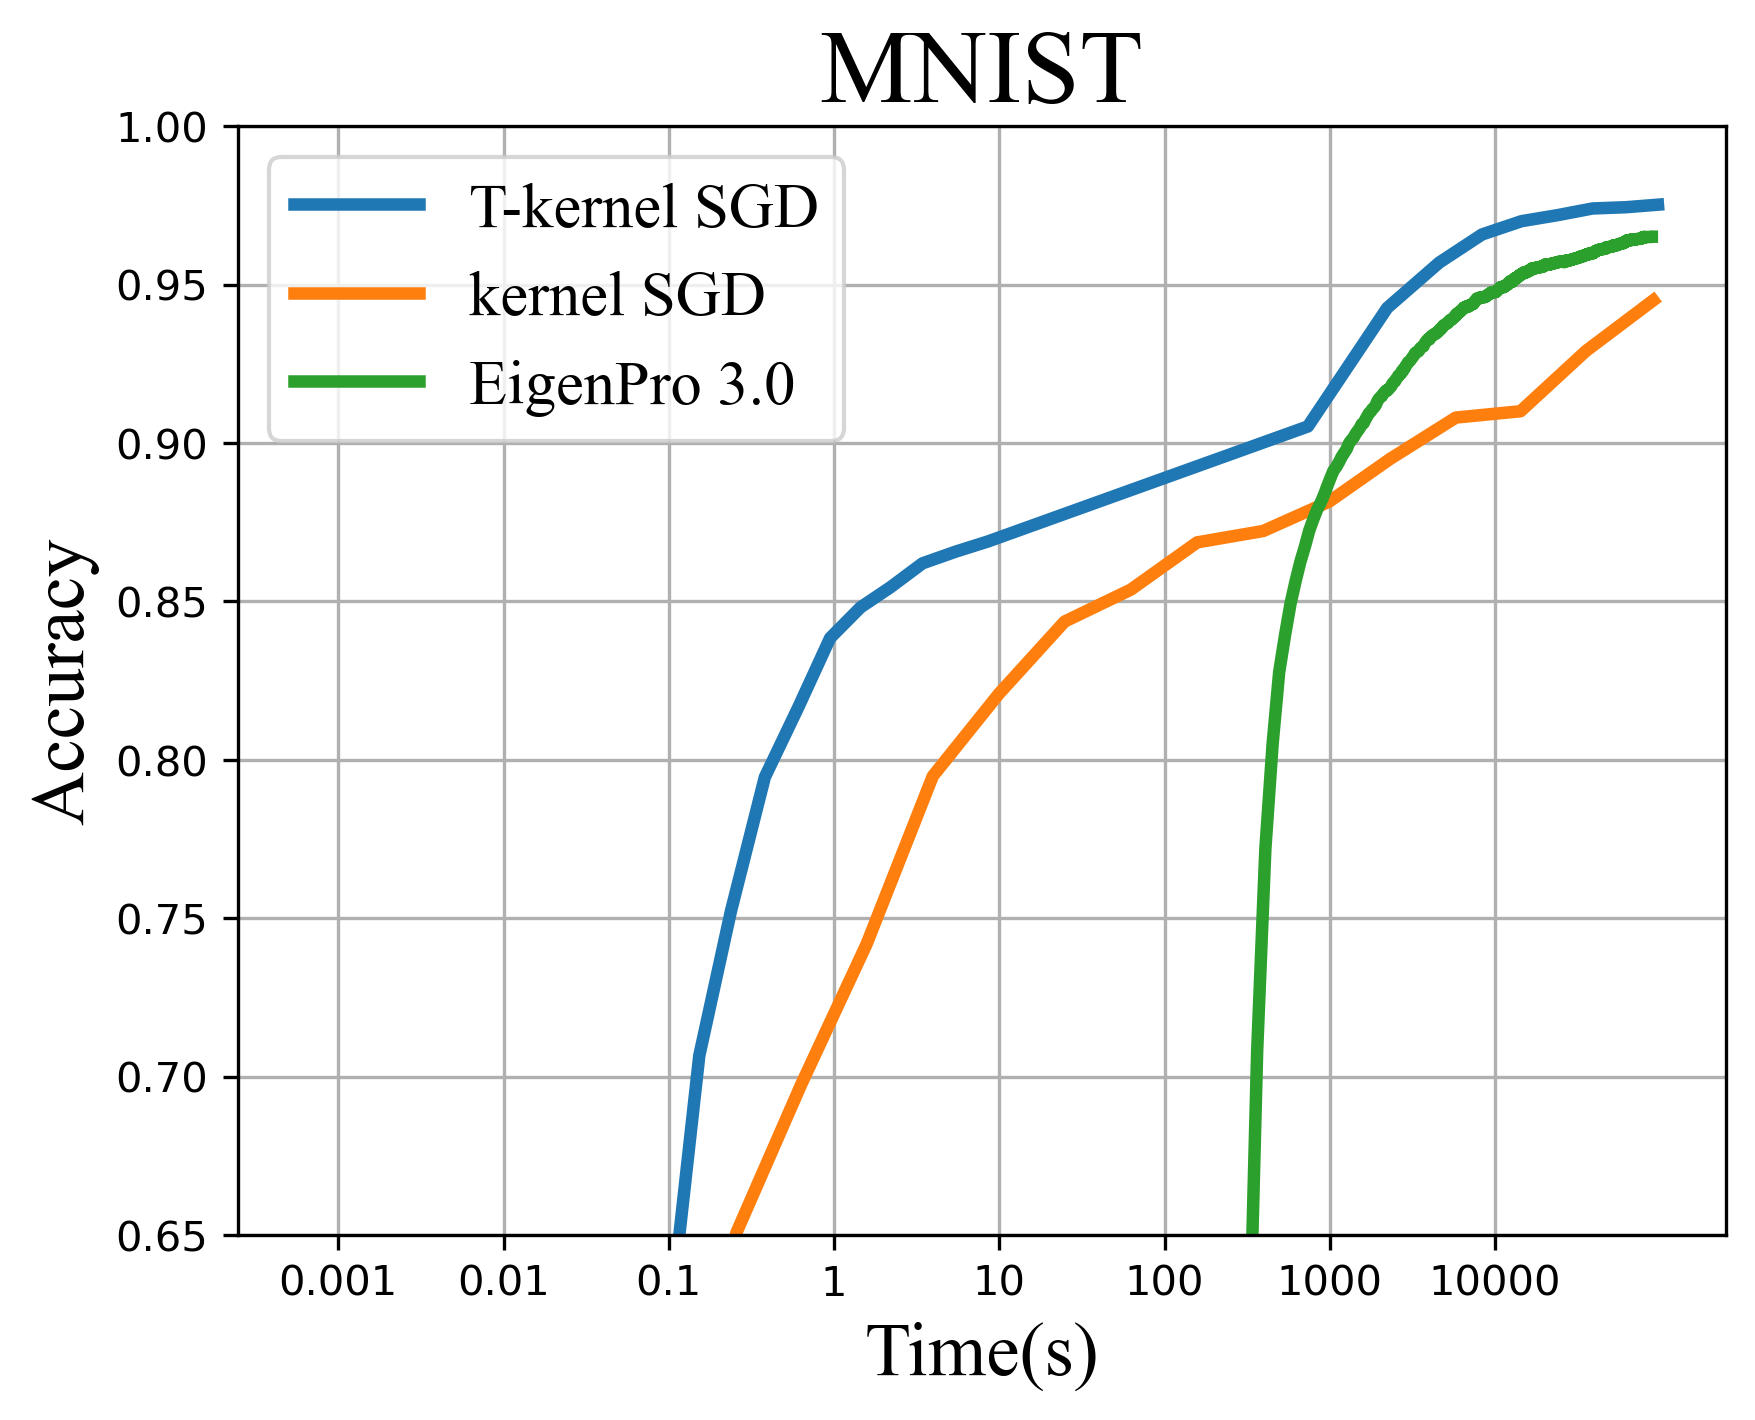

In [31]:
plt.figure(dpi=300)
plt.plot(T_time_kernel_sgd, Acc_t_kernel_sgd, label='T-kernel SGD',linewidth =3.0,color='#1f77b4')
plt.plot(T_kernel_sgd, Acc_kernel_sgd, label='kernel SGD',linewidth =3.0,color = '#ff7f0e')
plt.plot(T_eigen, Acc_eigen, label='EigenPro 3.0',linewidth =3.0,color='#2ca02c')
plt.ylim(0.65,1.)
plt.xticks(np.array([-3,-2,-1,0,1,2,3,4]),[0.001,0.01,0.1,1,10,100,1000,10000])
plt.xlabel('Time(s)',font={'family':'Times New Roman', 'size':18})
plt.ylabel('Accuracy',font={'family':'Times New Roman', 'size':18})
plt.title('MNIST', font={'family':'Times New Roman', 'size':25})
font1 = {'family' : 'Times New Roman',
'weight': 'normal',
'size' : 15,
}
plt.legend(prop=font1)
plt.grid()
fig = plt.gcf()
fig.savefig('MNIST.png')
plt.show()


In [72]:
len(T_eigen)

5218